# Imports

In [107]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import math
from pylab import rcParams
from pandas import read_excel
import glob

#define sub/superscripts
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
print("C2H5OH".translate(subscript))
superscript = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
print("PIr2".translate(superscript).replace('PI', 'π'))

matplotlib.rcParams['font.family'] = 'arial' 
matplotlib.rcParams['figure.figsize'] = 6, 4.5 #make a default fig size

C₂H₅OH
πr²


## Data imports and allocation

In [17]:
Files_CV = [] #blank list to fill with file paths

# Import files with same path and dtype with glob

for item in glob.glob('path*.DTA'):
    Files_CV.extend(
        [item]
    )
Files_CV.sort()
Files_CV = [Files_CV]

# There is a better way to do this but assign file names to paths

for num, param in enumerate(Files_CV):
    file1= param[0]
    file2= param[1]
    file3= param[2]
    file4= param[3]
    file5= param[4]
    file6= param[5]
    

## Defining Data in .DTA files

In [108]:
import os

def skip_to(fle, line, **kwargs):
### fle = input file name, line =  str that signifies start of dataset ###
    if os.stat(fle).st_size == 0:
        raise ValueError("File is empty")
    with open(fle) as f:
        pos = 0
        cur_line = f.readline()
        while not cur_line.startswith(line):
            pos = f.tell()
            cur_line = f.readline()
        f.seek(pos)
        return pd.read_csv(f, **kwargs)


## Data Import and interpolation

In [109]:
# Data import
file = file5
# Reads whole file, and makes a single dataframe with both CV and eQCM data
data = skip_to(file,"CURVE1", sep="	",usecols=(0,2,3,4,5),names=['name','Time','Q','Voltage','Current'],skiprows=3)
data = pd.DataFrame(data)

# location where eQCM data starts
cut = data[data['name'] == 'QCMCurve'].index[0]

# EQCM time offset
eqcm_time = data.at[cut-2, 'Time']

# Making a CV dataframe
data_CV = data.copy()
data_CV.drop(data_CV.tail( (len(data.index) + 5) - cut).index,inplace=True)
data_CV.drop('name',axis=1,inplace=True)
# Convert E to e for python
# Python doesn't recognize E as scientific notation
data_CV.apply(lambda x: x.astype(str).str.lower())
data_CV = data_CV.apply(pd.to_numeric, errors='coerce').dropna()
data_CV = data_CV.set_index(data_CV['Time'])

# Making an eQCM dataframe
data_eQCM = data.copy()
data_eQCM.rename(columns={'Q': 'fs', 'Voltage': 'fp','Current': 'chisq'}, inplace=True)
data_eQCM.drop(data_eQCM.head(cut+3).index,inplace=True)
data_eQCM.drop('name',axis=1,inplace=True)

data_eQCM.apply(lambda x: x.astype(str).str.lower())
data_eQCM = data_eQCM.apply(pd.to_numeric, errors='coerce').dropna()
data_eQCM['Time'] = data_eQCM['Time'].sub(int(float(eqcm_time)))
data_eQCM = data_eQCM.set_index(data_eQCM['Time'])

data_compiled = pd.concat([data_CV, data_eQCM], ignore_index=True, sort=False)
data_compiled = data_compiled.set_index(data_compiled['Time']).sort_index().interpolate()

data_compiled = data_compiled.rename(columns={'Time': 't'})
# forward fill data

#data_compiled.ffill(inplace=True)
print(data_compiled)

                     t             Q   Voltage       Current        fs  \
Time                                                                     
0.040000      0.040000 -3.225400e-08 -0.680853 -8.063500e-07       NaN   
0.080000      0.080000 -1.183490e-07 -0.682855 -2.152380e-06       NaN   
0.120000      0.120000 -2.526970e-07 -0.684909 -3.358710e-06       NaN   
0.160000      0.160000 -4.290420e-07 -0.686907 -4.408600e-06       NaN   
0.200000      0.200000 -6.473630e-07 -0.688913 -5.458040e-06       NaN   
...                ...           ...       ...           ...       ...   
119.879997  119.879997  4.669640e-04 -0.672984 -2.750190e-05  9.975714   
119.919998  119.919998  4.658080e-04 -0.675006 -2.889440e-05  9.975714   
119.920000  119.920000  4.652025e-04 -0.676001 -2.958455e-05  9.975714   
119.959999  119.959999  4.645970e-04 -0.676996 -3.027470e-05  9.975714   
120.000000  120.000000  4.633300e-04 -0.678993 -3.166830e-05  9.975714   

                  fp  chisq  
Time   

### Cyclic Voltammetry Specific Data Import

In [110]:
#Cyclic Voltammetry

cycles = 5 #number of CVs in this dataset

# note - this code assumes all cvs were taken with same scan rate, 
# at even time intervals, without rest steps.

##################################################
# This adds a column to the df with cycle number #
##################################################

time = data_compiled['t'].iloc[-1] #pull last time value
i = time/cycles #find time ranges

cycle = [] # empty array to fill in loop
n = 1 #starting cycle number


for x in range(1,cycles+1): #for each cycle, assign range
    t1 = (x * i) - i #lower bound
    t2 = (x * i)  # upper bound

    for y  in data_compiled['t']:
        if t1 < y <= t2: # check if time value lies within the range for the cycle
            cycle.append(n) # if in time range, will append the cycle number to cycle array
        
    n = n+1 # increase cycle number before next loop

data_compiled['Cycle'] = cycle # turn array into df column

# Group df by cycle number

DBC = data_compiled.groupby("Cycle") # data by cycle

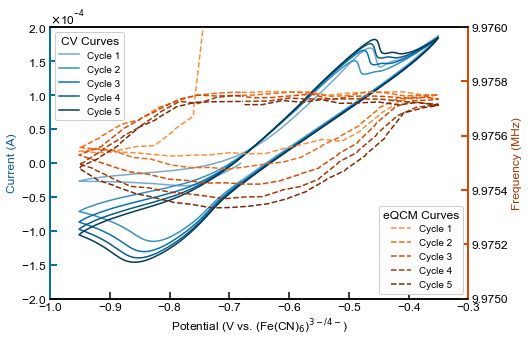

In [114]:
matplotlib.rcParams['figure.figsize'] = 7.5, 5 #(I don't use this)
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['axes.linewidth'] = 1.5

Colors_CV = ['#74a9cf','#3690c0','#0570b0','#045a8d','#023858']
Colors_eQCM = ['#fd8d3c','#f16913','#d94801','#a63603','#7f2704']

#Cs = ['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000'] #cv colors


####################
cycles = 5 #number of CVs in this dataset

cycle = range(1,cycles+1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

for num, param in enumerate(zip(Colors_CV, Colors_eQCM, cycle)):
    
    C1 = param[0]
    C2 = param[1]
    cyclex = param[2]
    
    x = DBC.get_group(cyclex)['Voltage']
    y1 = DBC.get_group(cyclex)['Current']
    y2 = DBC.get_group(cyclex)['fs']
    
    ax2.plot(x,y2,color=C2,linestyle = '--',label = "Cycle "+str(cyclex))
    ax.plot(x,y1,color=C1, label = "Cycle "+str(cyclex))
    #ax2.plot(x,y2,color=C2,linestyle = '--',label = "Cycle "+str(cyclex))
        
ax.set_xlabel(r'Potential (V vs. (Fe(CN)$_{6}$)$^{3-/4-}$)',fontsize=12)
ax.set_ylabel('Current (A)',fontsize=12)
ax.set_xlim(-1,-0.3)
ax.ticklabel_format(style='sci',useMathText=True,  axis='y', scilimits=(0,0))
#ax2.ticklabel_format(style='sci',useMathText=True,  axis='y', scilimits=(0,0))
ax2.set_ylim(9.97,9.98)
ax.set_ylim(-0.0002,0.0002)

ax.legend(loc="upper left",title = "CV Curves",fontsize=10,fancybox=True, frameon=True,framealpha=1)
ax2.legend(loc="lower right",title = "eQCM Curves", fontsize=10,fancybox=True, frameon=True,framealpha=1)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Frequency (MHz)',color='k',fontsize=12)   
ax2.set_ylim(9.975,9.976)

ax2.spines['left'].set_color('#0570b0')
ax2.spines['left'].set_linewidth(2)
ax2.spines['right'].set_color('#d94801')
ax.yaxis.label.set_color('#045a8d')
ax2.spines['right'].set_linewidth(2)
ax2.yaxis.label.set_color('#a63603')
ax.tick_params(axis='y',color='#0570b0',direction='in',length=7,width=2)
ax2.tick_params(axis='y',color='#d94801',direction='in',length=7,width=2)
ax.tick_params(axis='x',direction ='in',length=7,width=1.5)

plt.savefig('Sn_Calibration_CV5.png',dpi=300)

plt.show()

